In [6]:
import os
import torch
import pickle
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, losses, SentencesDataset, InputExample, models
from transformers import AutoTokenizer, AutoModel
import os
import pickle
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from transformers import AutoTokenizer, AutoModel
import h3
from tqdm import tqdm
import folium
from folium import features

In [7]:
input_pickle_path = 'DataSet_triplet/PUNJAB_05_without_city.pkl'

with open(input_pickle_path, 'rb') as f:
    data = pickle.load(f)

triplets = data.get('triplets', [])
addresses = data.get('addresses', [])
lat_lngs = data.get('lat_lngs', [])

print(f"Length of triplets: {len(triplets)}, {triplets[-1]}")
print(f"Length of addresses: {len(addresses)}, {addresses[-1]}")
print(f"Length of lat_lngs: {len(lat_lngs)}, {lat_lngs[-1]}")

Length of triplets: 3217904, (1114168, 1114167, 1114099, 3)
Length of addresses: 1114180, wardno 1 vpo sarhala ranuan
Length of lat_lngs: 1114180, [31.2044125, 75.8583784]


In [8]:
import os
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel
import h3
from tqdm import tqdm
import folium

def get_embedding(model, text, tokenizer, device):
    inputs = tokenizer(text, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

def get_embeddings(model, texts, tokenizer, device):
    embeddings = [get_embedding(model, text, tokenizer, device) for text in tqdm(texts, desc="Computing embeddings")]
    return np.vstack(embeddings)

def plot_tsne_of_neighbouring_grids(models, tokenizers, devices, addresses, lat_lngs, resolution=10, output_dir='output_plots', perplexity=10):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate H3 indices for the provided latitudes and longitudes at the current resolution
    h3_indices = [h3.geo_to_h3(lat, lng, resolution) for lat, lng in lat_lngs]

    # Select a random center grid
    unique_grids = list(set(h3_indices))
    center_grid = str(np.random.choice(unique_grids))  # Convert to regular string

    # Move to parent grid of the selected center grid
    parent_grid = h3.h3_to_parent(center_grid, resolution - 1)
    
    # Generate new H3 indices for the lat_lngs at the parent resolution
    parent_h3_indices = [h3.geo_to_h3(lat, lng, resolution - 1) for lat, lng in lat_lngs]
    
    # Find neighbors from the parent's 1-skip neighbor onwards
    first_order_neighbours = h3.k_ring(parent_grid, 1)
    second_order_neighbours = h3.k_ring(parent_grid, 2)
    third_order_neighbours = h3.k_ring(parent_grid, 3)
    
    selected_grids = first_order_neighbours | second_order_neighbours | third_order_neighbours
    
    # Filter addresses that fall within the selected grids at parent resolution
    grid_to_addresses = {grid: [] for grid in selected_grids}
    for i in range(len(addresses)):
        if parent_h3_indices[i] in selected_grids:
            grid_to_addresses[parent_h3_indices[i]].append(addresses[i])
    
    # Filter grids that have at least 4 addresses
    filtered_grids = {grid: addr_list for grid, addr_list in grid_to_addresses.items() if len(addr_list) > 4}
    
    # Select only 10 grids randomly
    selected_grids = list(filtered_grids.keys())
    if len(selected_grids) > 10:
        selected_grids = np.random.choice(selected_grids, 10, replace=False)
    
    selected_addresses = [addr for grid in selected_grids for addr in filtered_grids[grid]]
    selected_h3_indices = [grid for grid in selected_grids for _ in filtered_grids[grid]]
    
    # Plot t-SNE for each model
    for model, tokenizer, device, model_name in zip(models, tokenizers, devices, ['Model R(Pan-India)', 'Model-Rc', 'Model R-T' , 'Moedl R-untrained']):
        embeddings = get_embeddings(model, selected_addresses, tokenizer, device)
        if embeddings.size == 0:
            continue
        
        # Apply t-SNE on the embeddings
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        tsne_embeddings = tsne.fit_transform(embeddings)

        # Plot the t-SNE embeddings
        plt.figure(figsize=(12, 8))
        sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=selected_h3_indices, palette="tab10")
        plt.title(f't-SNE Plot of Address Embeddings in Neighbouring Grids ({model_name})')
        plt.legend(title='Grid ID')
        plt.savefig(os.path.join(output_dir, f'tsne_neighbouring_grids_{model_name}.png'))
        plt.show()
    
    return [str(grid) for grid in selected_grids]  # Ensure all grids are regular strings

def plot_h3_grids_neighbours(lat_lngs, selected_grids, resolution=10, output_path='h3_neighbouring_grids_plot.png'):
    plt.figure(figsize=(12, 8))
    for grid in selected_grids:
        boundary = h3.h3_to_geo_boundary(str(grid))  # Convert to regular string
        boundary = list(boundary) + [boundary[0]]  
        boundary = np.array(boundary)
        plt.plot(boundary[:, 1], boundary[:, 0], 'k-')  
        plt.fill(boundary[:, 1], boundary[:, 0], alpha=0.4)

    plt.title('H3 Neighbouring Grid Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig(output_path)
    plt.show()

def plot_h3_grids_folium_neighbours(lat_lngs, selected_grids, resolution=10, output_path='h3_neighbouring_grids_map.html'):
    center_lat = np.mean([lat for lat, lng in lat_lngs])
    center_lng = np.mean([lng for lat, lng in lat_lngs])
    map_folium = folium.Map(location=[center_lat, center_lng], zoom_start=12)

    for grid in selected_grids:
        boundary = h3.h3_to_geo_boundary(str(grid))  # Convert to regular string
        boundary = [(lat, lng) for lat, lng in boundary]  
        boundary.append(boundary[0])  
        
        folium.Polygon(locations=boundary, color='blue', fill=True, fill_opacity=0.4).add_to(map_folium)

    map_folium.save(output_path)

    return map_folium

def load_finetuned_model(checkpoint_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AutoModel.from_pretrained(checkpoint_path)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
    model = model.to(device)
    return model, tokenizer, device
    
# checkpoint_paths = ['/home/uddeshya.singh/R-model(MLM-pan)/pan_india_train_threshold_save_dir', '/home/devanapalli.ravi/disk_1/paper/data/untrained_models/distilroberta-base/', '/home/uddeshya.singh/Experiments/punjab_combined_triplet_train(amazon)/checkpoint_epoch_am9']
# models, tokenizers, devices = zip(*[load_finetuned_model(path) for path in checkpoint_paths])


Computing embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 815/815 [00:08<00:00, 93.98it/s]


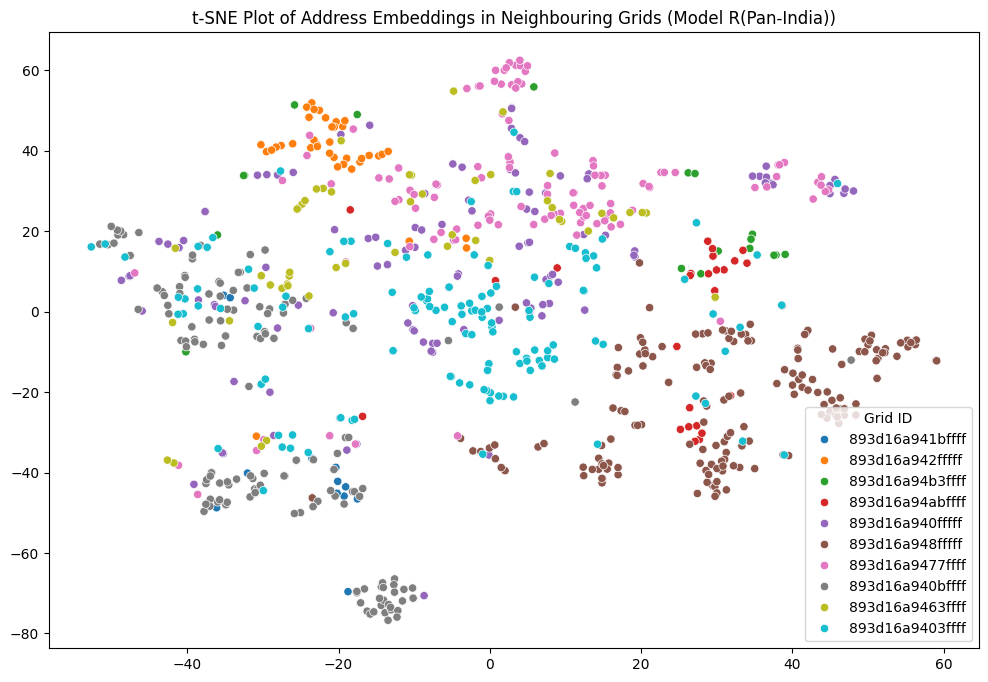

Computing embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 815/815 [00:08<00:00, 95.25it/s]


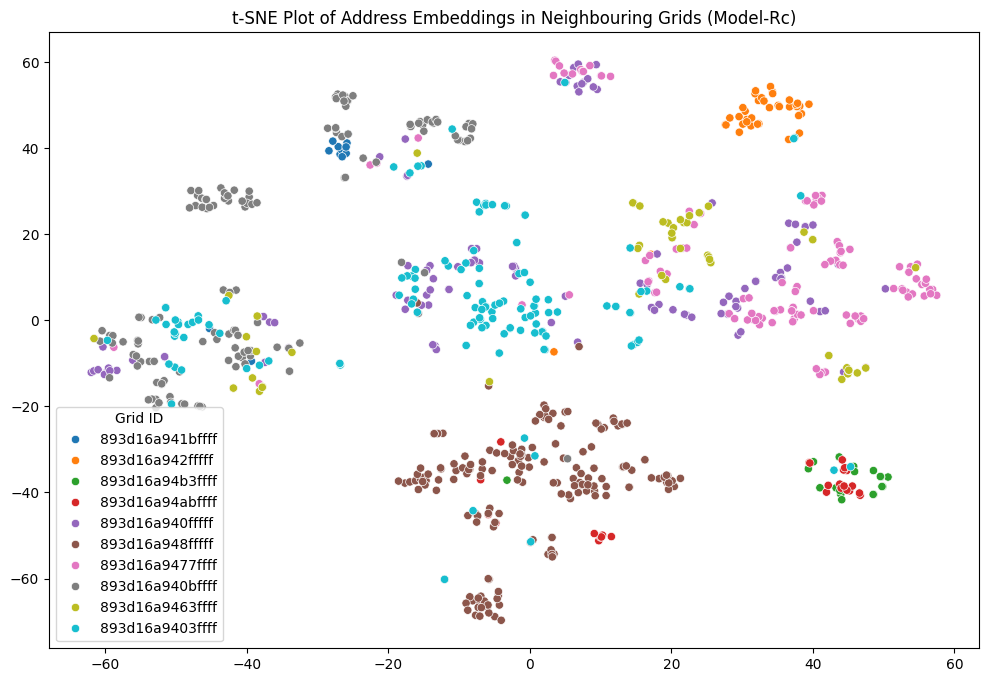

Computing embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 815/815 [00:08<00:00, 99.61it/s]


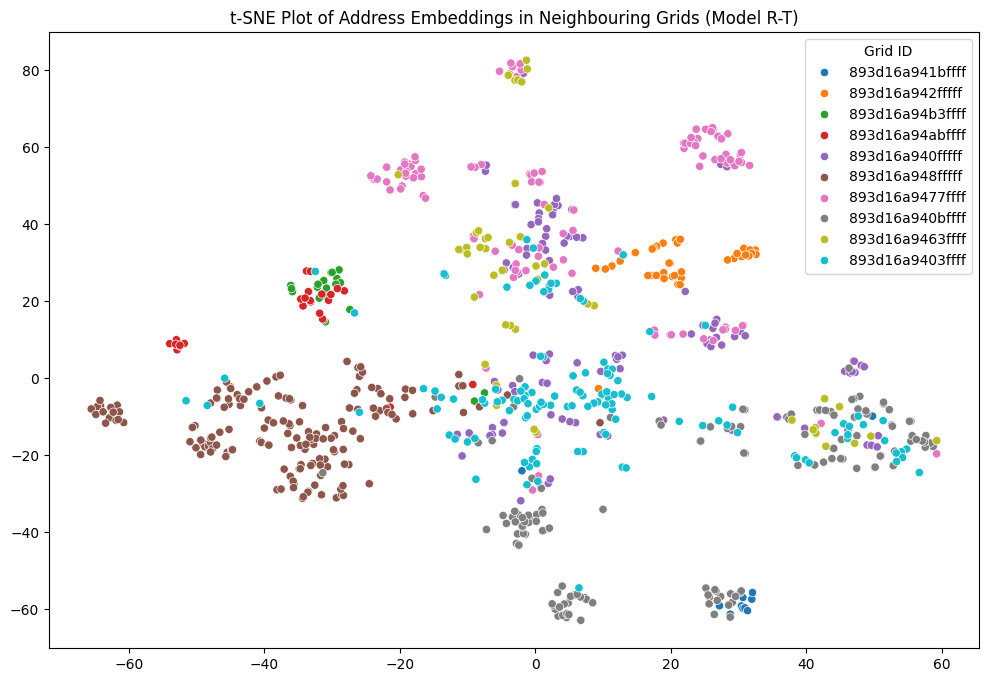

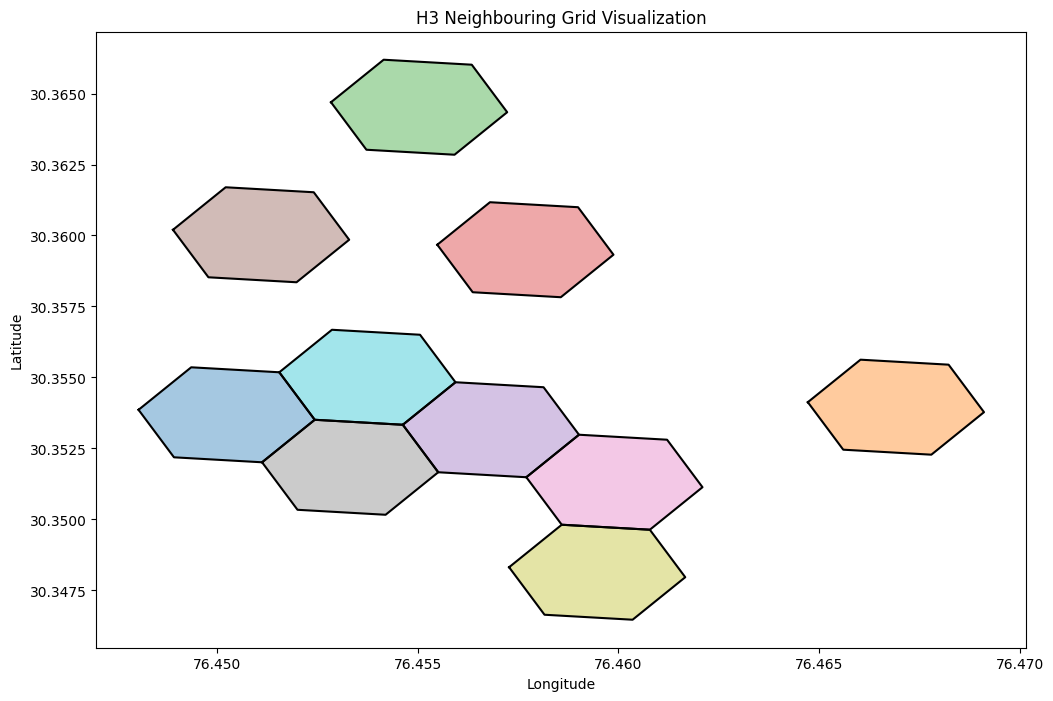

In [6]:
selected_grids = plot_tsne_of_neighbouring_grids(models, tokenizers, devices, addresses, lat_lngs, resolution=10, output_dir='output_plots', perplexity=10)
if selected_grids:
    plot_h3_grids_neighbours(lat_lngs, selected_grids, resolution=10, output_path='output_plots/h3_neighbouring_grids_plot.png')
    plot_h3_grids_folium_neighbours(lat_lngs, selected_grids, resolution=10, output_path='output_plots/h3_neighbouring_grids_map.html')

In [9]:
checkpoint_paths = ['/home/uddeshya.singh/R-model(MLM-pan)/pan_india_train_threshold_save_dir', '/home/uddeshya.singh/Models/model-classification-r-checkpoint-260000', '/home/uddeshya.singh/Experiments/punjab_combined_triplet_train(amazon)/checkpoint_epoch_am9', '/home/devanapalli.ravi/disk_1/paper/data/untrained_models/distilroberta-base/']
models, tokenizers, devices = zip(*[load_finetuned_model(path) for path in checkpoint_paths])


Some weights of RobertaModel were not initialized from the model checkpoint at /home/uddeshya.singh/R-model(MLM-pan)/pan_india_train_threshold_save_dir and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at /home/uddeshya.singh/Models/model-classification-r-checkpoint-260000 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Computing embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 95.01it/s]


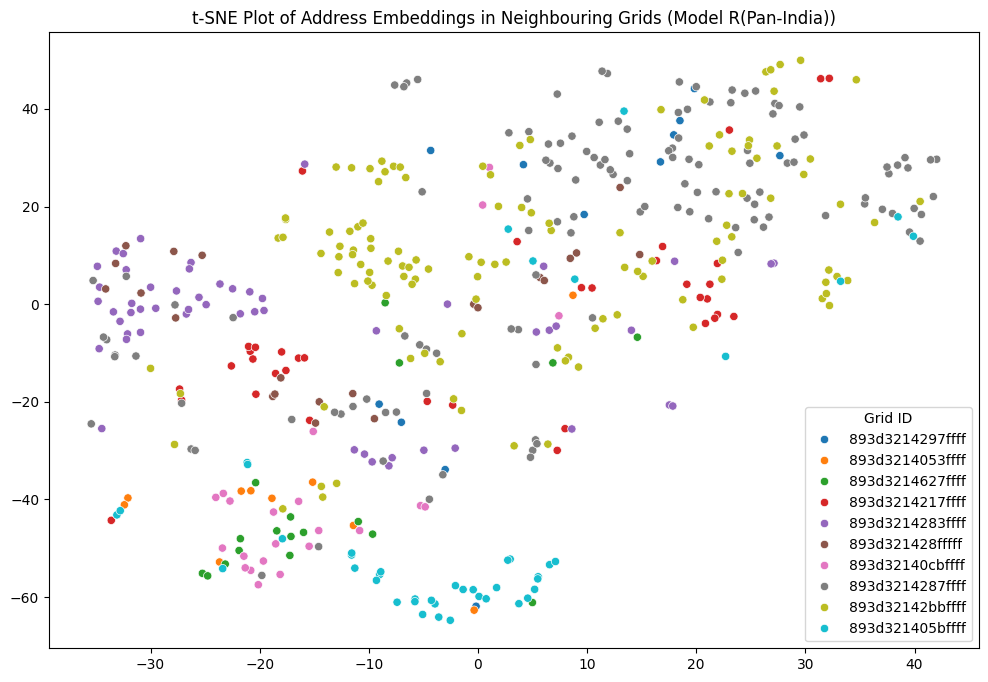

Computing embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 96.26it/s]


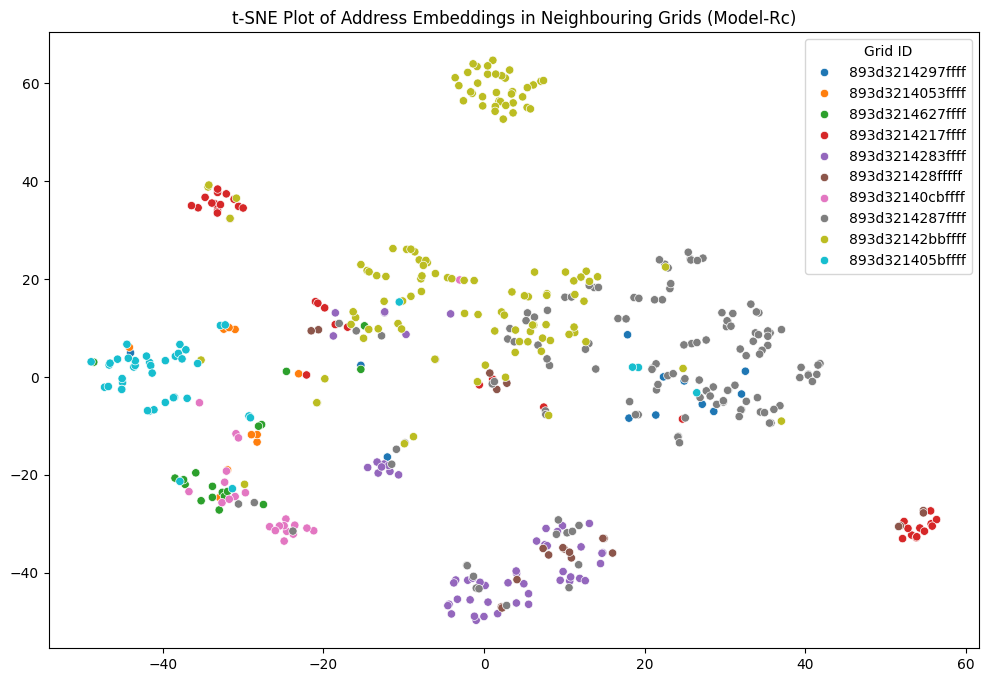

Computing embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 97.11it/s]


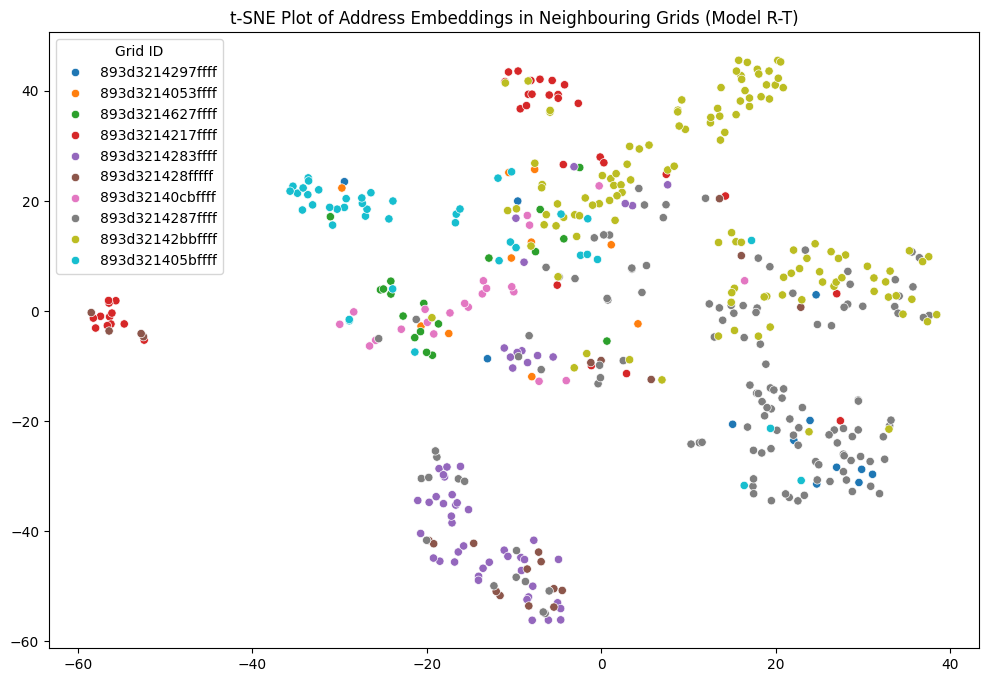

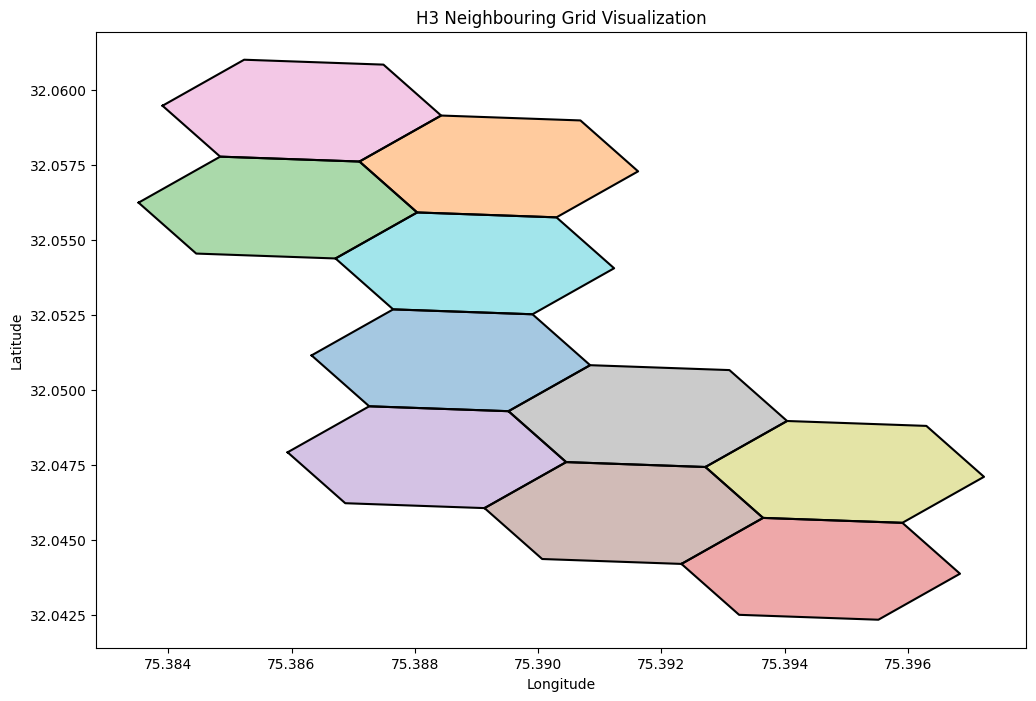

In [6]:
selected_grids = plot_tsne_of_neighbouring_grids(models, tokenizers, devices, addresses, lat_lngs, resolution=10, output_dir='output_plots', perplexity=10)
if selected_grids:
    plot_h3_grids_neighbours(lat_lngs, selected_grids, resolution=10, output_path='output_plots/h3_neighbouring_grids_plot.png')
    plot_h3_grids_folium_neighbours(lat_lngs, selected_grids, resolution=10, output_path='output_plots/h3_neighbouring_grids_map.html')

Computing embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 816/816 [00:08<00:00, 94.65it/s]


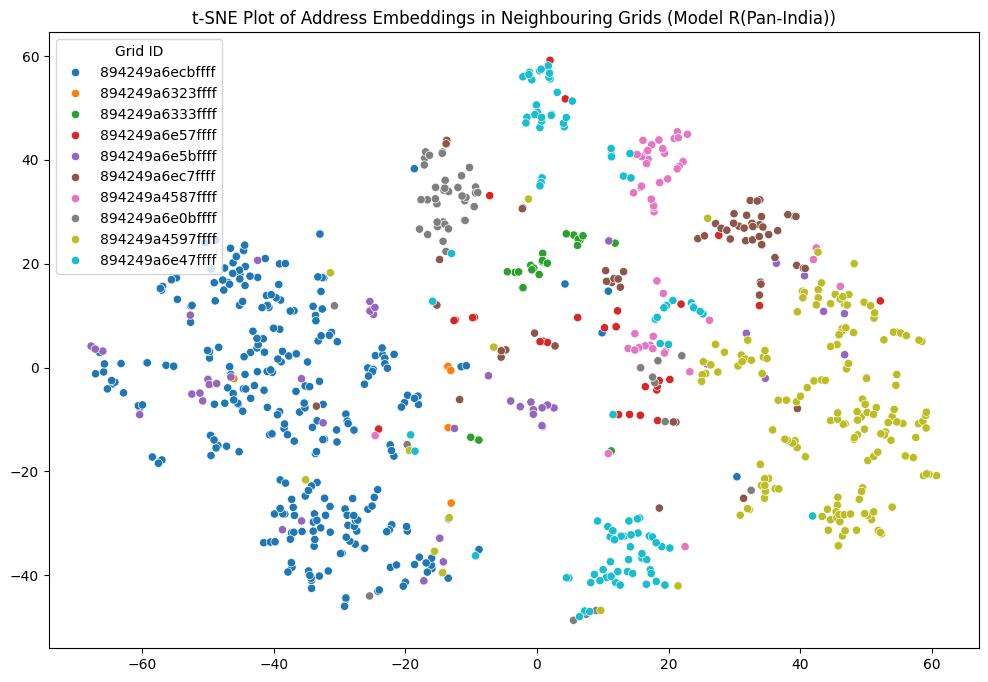

Computing embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 816/816 [00:08<00:00, 96.96it/s]


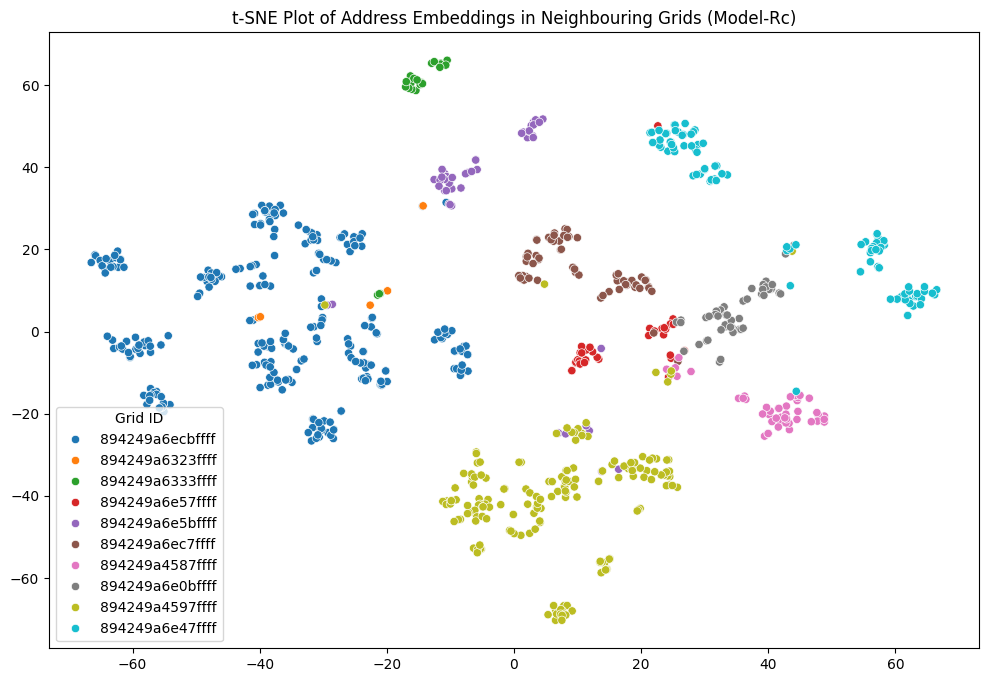

Computing embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 816/816 [00:08<00:00, 93.96it/s]


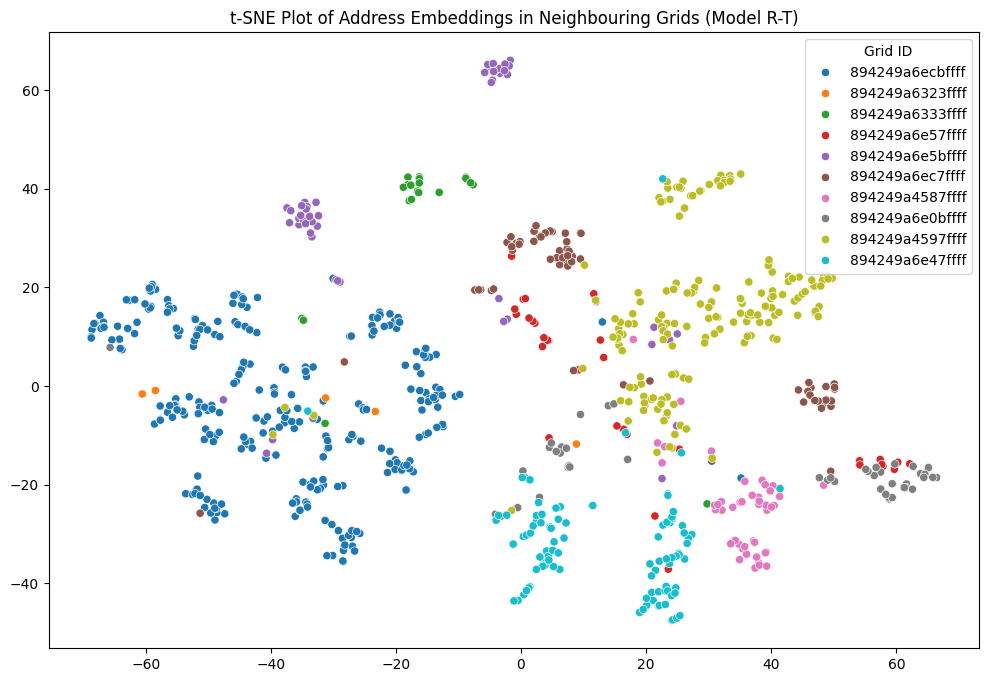

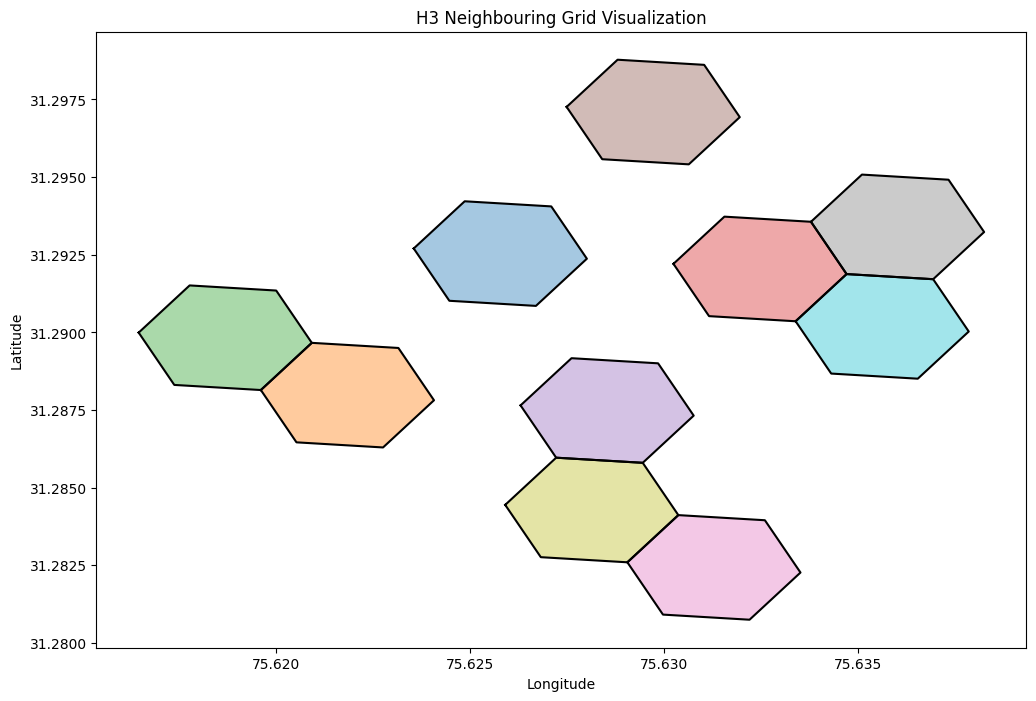

In [7]:
selected_grids = plot_tsne_of_neighbouring_grids(models, tokenizers, devices, addresses, lat_lngs, resolution=10, output_dir='output_plots', perplexity=10)
if selected_grids:
    plot_h3_grids_neighbours(lat_lngs, selected_grids, resolution=10, output_path='output_plots/h3_neighbouring_grids_plot.png')
    plot_h3_grids_folium_neighbours(lat_lngs, selected_grids, resolution=10, output_path='output_plots/h3_neighbouring_grids_map.html')

Computing embeddings: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1244/1244 [00:12<00:00, 101.47it/s]


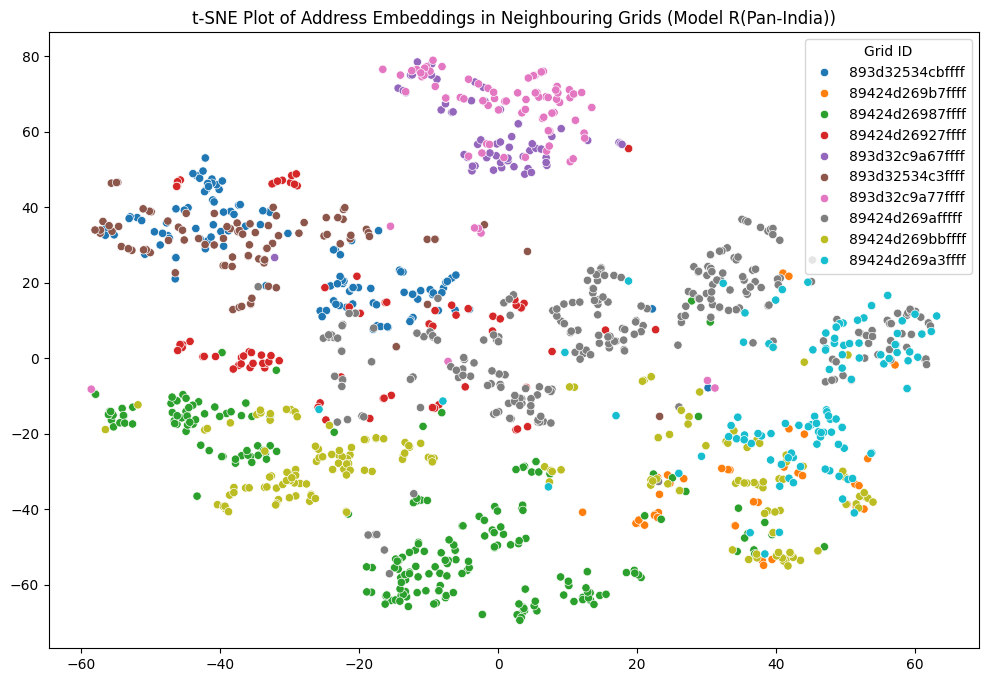

Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1244/1244 [00:13<00:00, 95.43it/s]


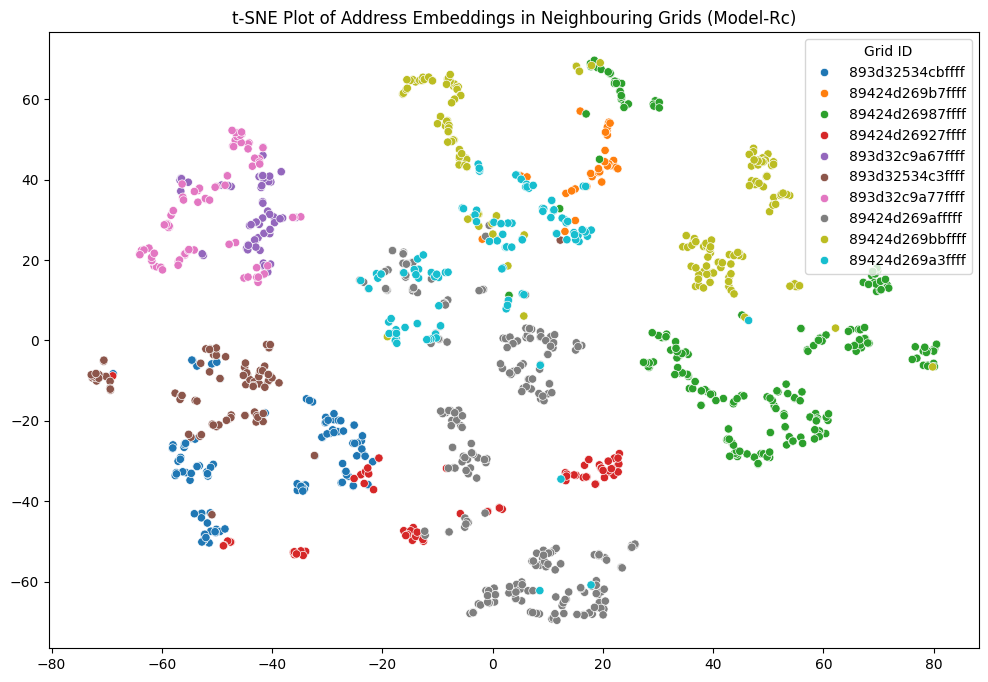

Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1244/1244 [00:12<00:00, 96.41it/s]


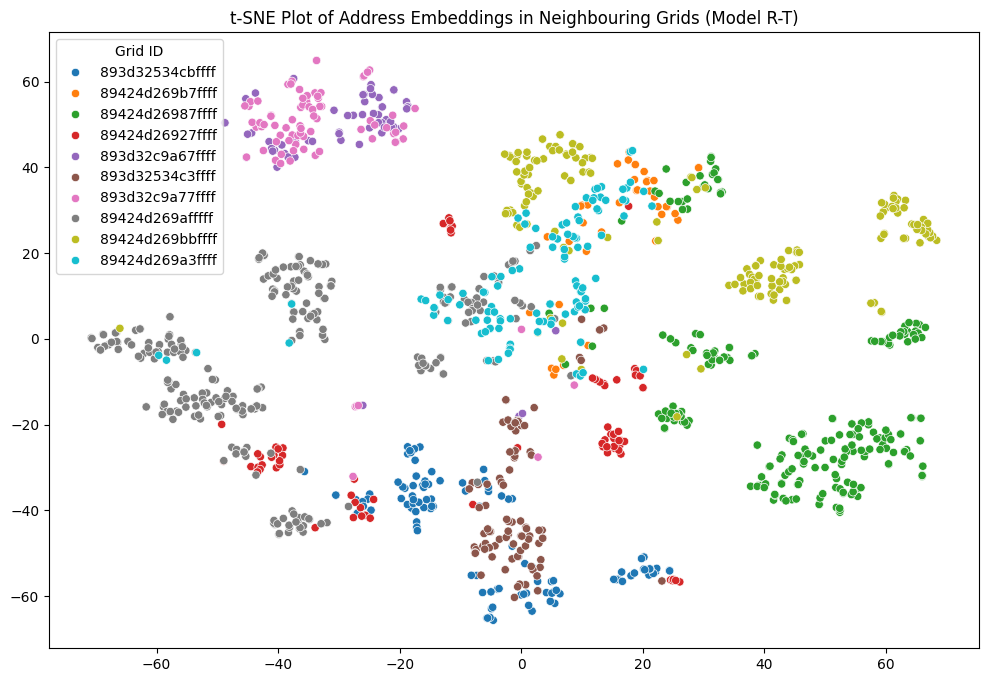

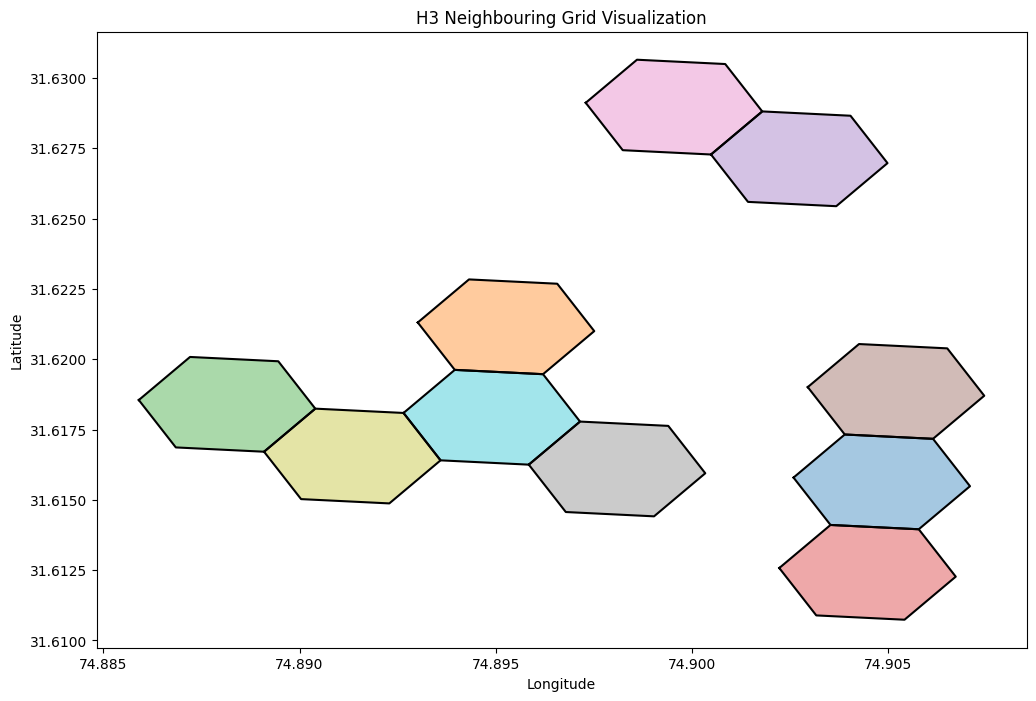

In [15]:
selected_grids = plot_tsne_of_neighbouring_grids(models, tokenizers, devices, addresses, lat_lngs, resolution=10, output_dir='output_plots', perplexity=10)
if selected_grids:
    plot_h3_grids_neighbours(lat_lngs, selected_grids, resolution=10, output_path='output_plots/h3_neighbouring_grids_plot.png')
    plot_h3_grids_folium_neighbours(lat_lngs, selected_grids, resolution=10, output_path='output_plots/h3_neighbouring_grids_map.html')

Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1431/1431 [00:15<00:00, 95.15it/s]


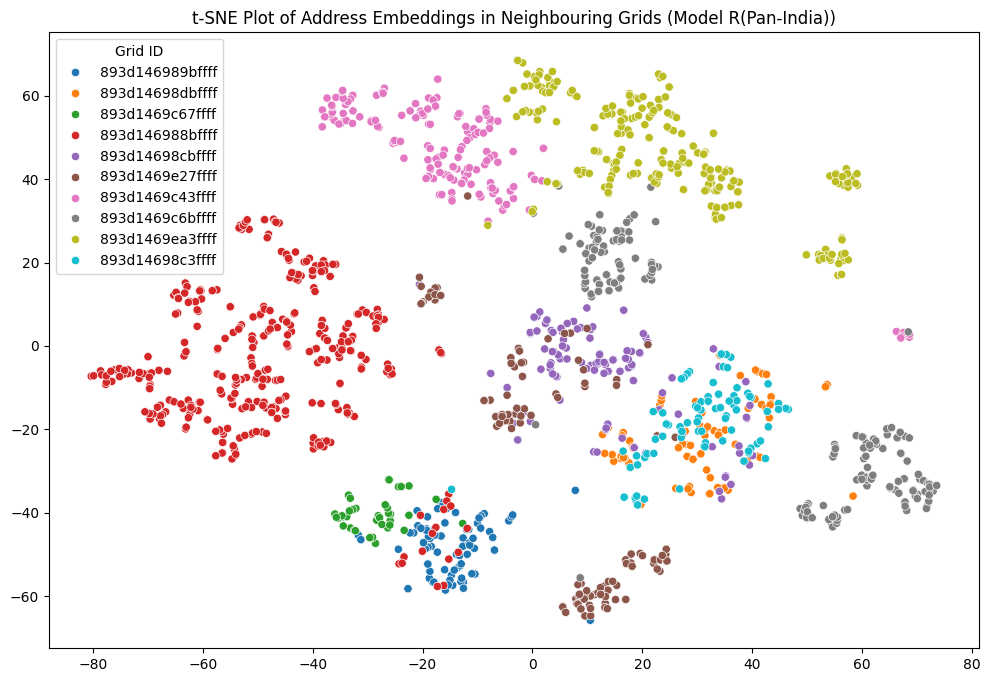

Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1431/1431 [00:15<00:00, 94.91it/s]


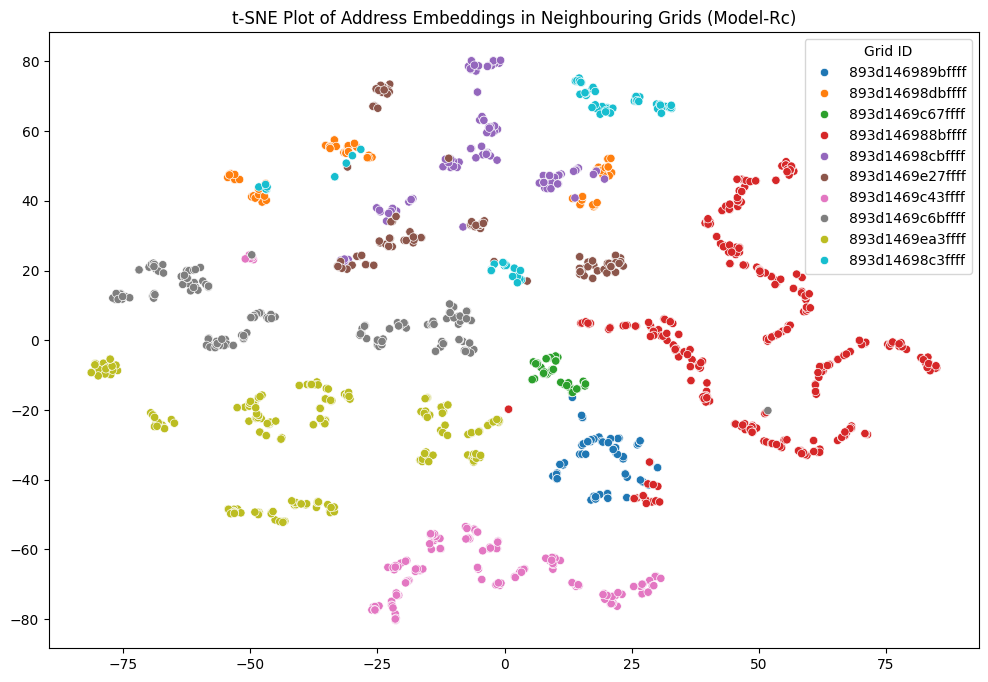

Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1431/1431 [00:15<00:00, 94.17it/s]


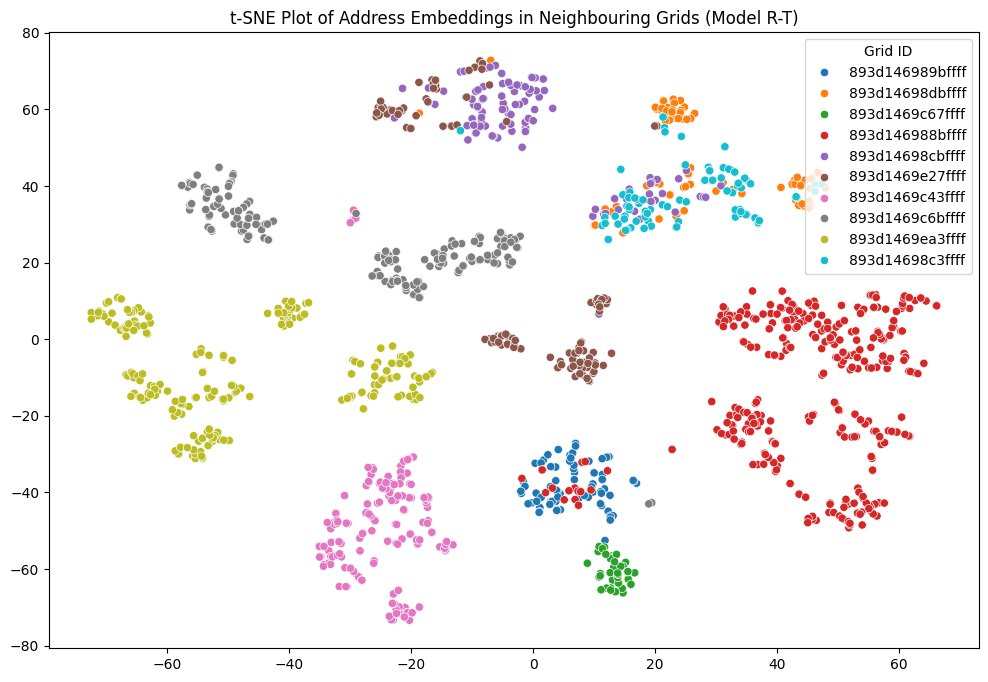

Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1431/1431 [00:15<00:00, 93.69it/s]


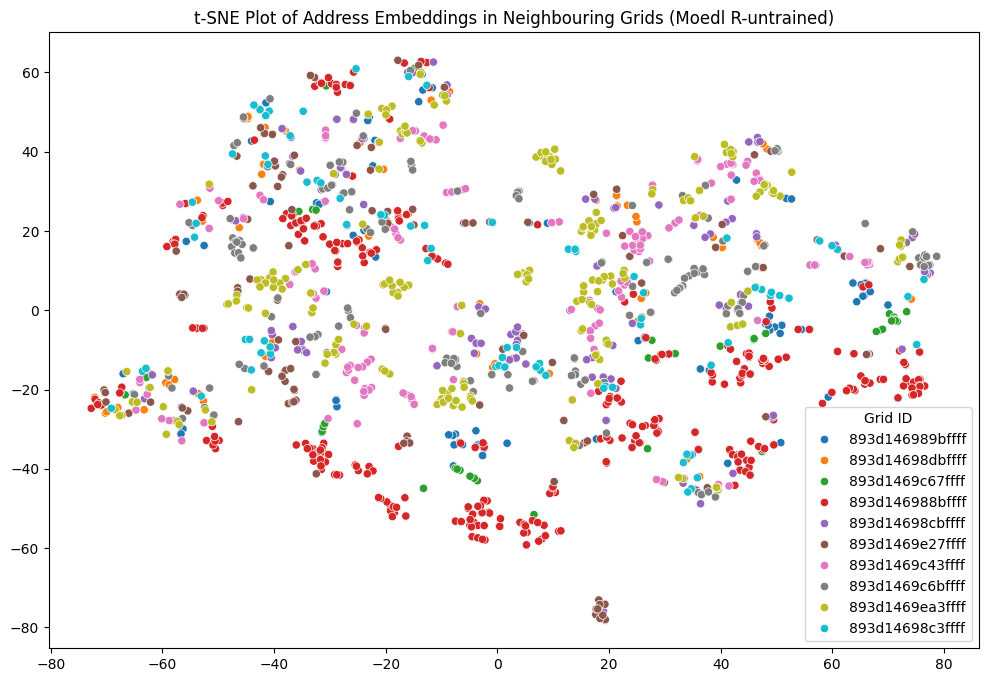

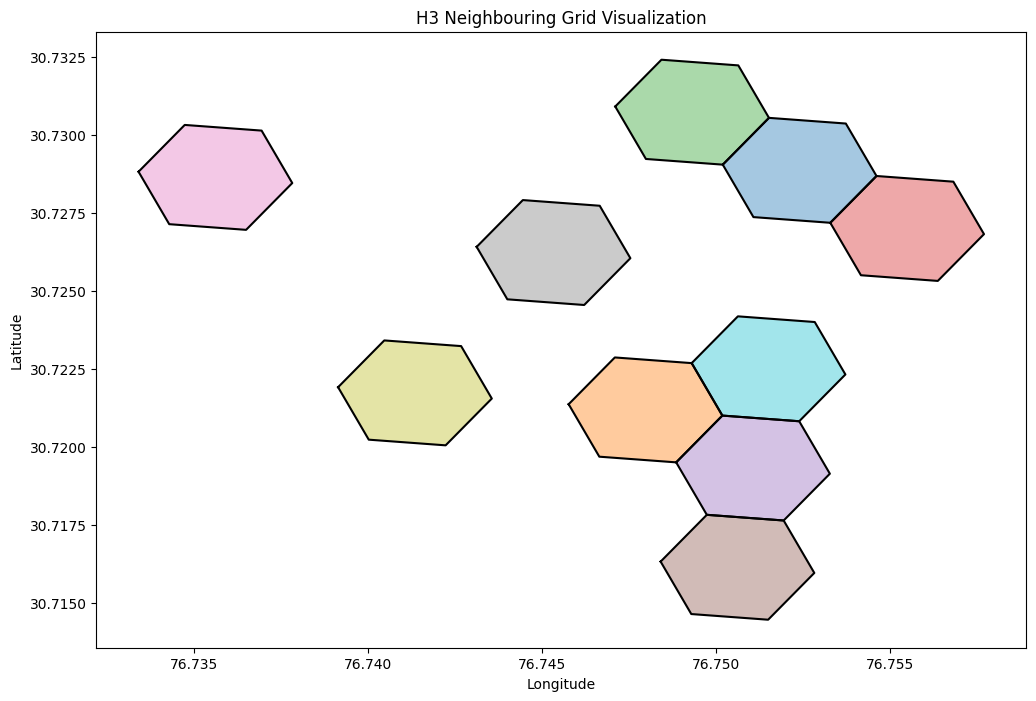

In [8]:
selected_grids = plot_tsne_of_neighbouring_grids(models, tokenizers, devices, addresses, lat_lngs, resolution=10, output_dir='output_plots', perplexity=10)
if selected_grids:
    plot_h3_grids_neighbours(lat_lngs, selected_grids, resolution=10, output_path='output_plots/h3_neighbouring_grids_plot.png')
    plot_h3_grids_folium_neighbours(lat_lngs, selected_grids, resolution=10, output_path='output_plots/h3_neighbouring_grids_map.html')

Computing embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 574/574 [00:06<00:00, 95.20it/s]


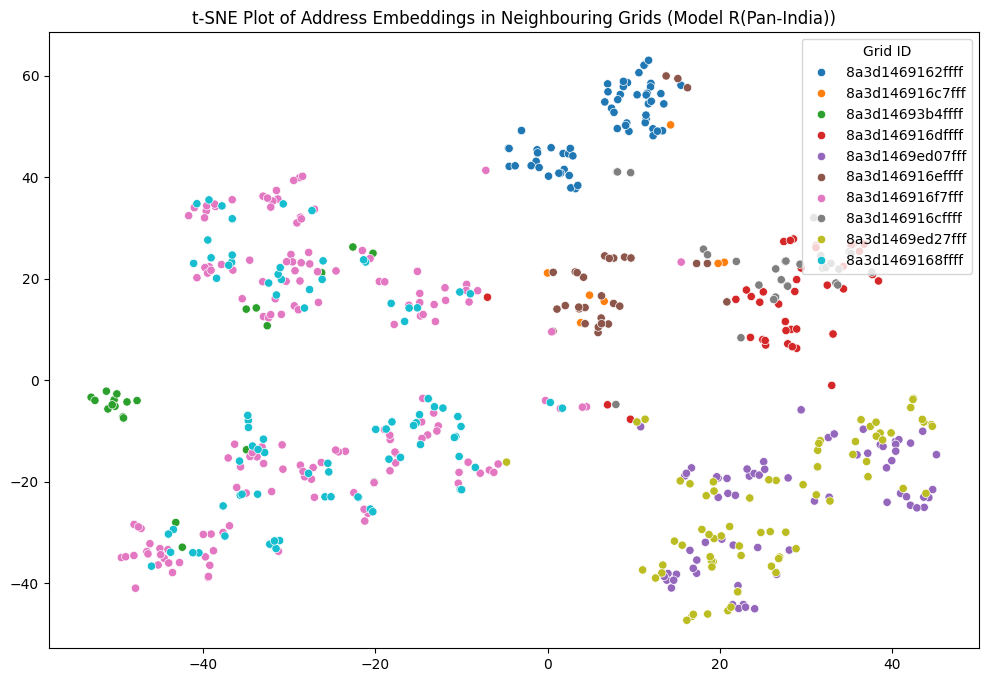

Computing embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 574/574 [00:06<00:00, 94.58it/s]


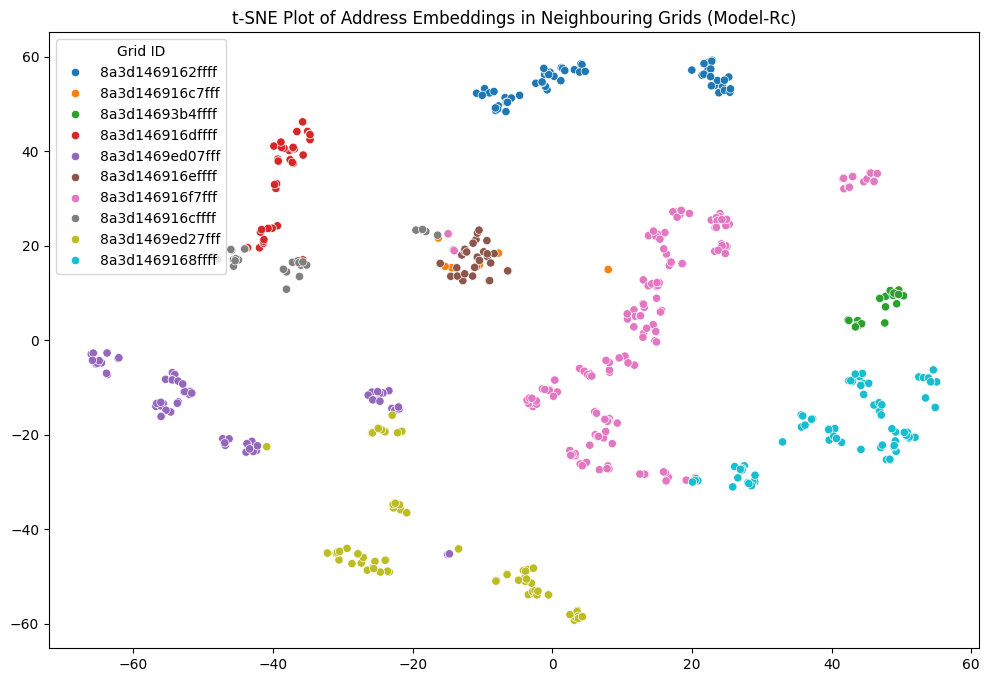

Computing embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 574/574 [00:06<00:00, 94.96it/s]


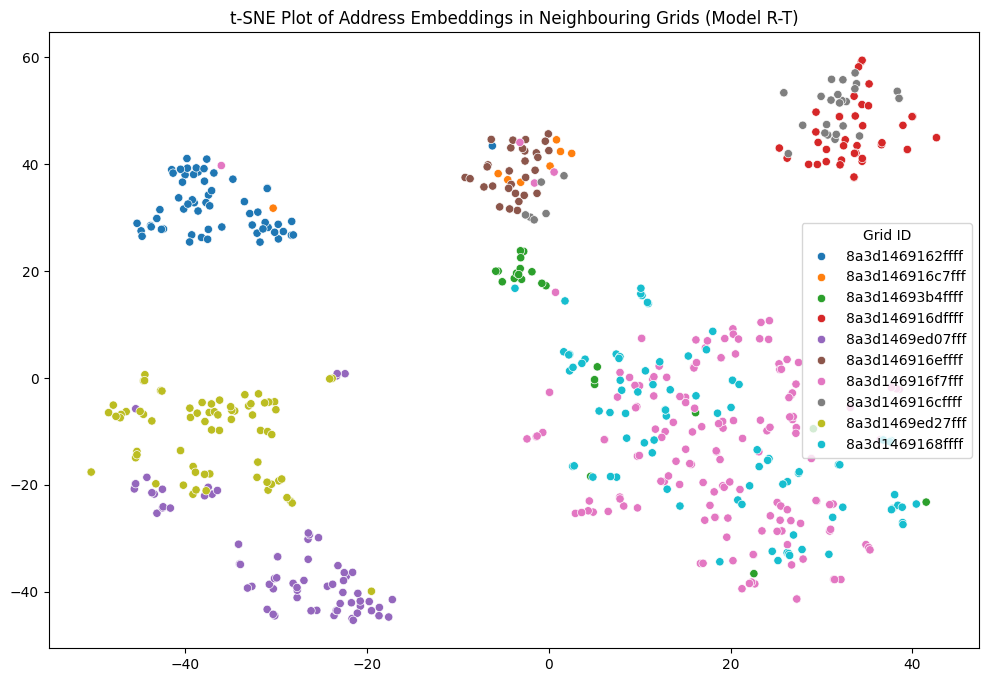

Computing embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 574/574 [00:06<00:00, 94.97it/s]


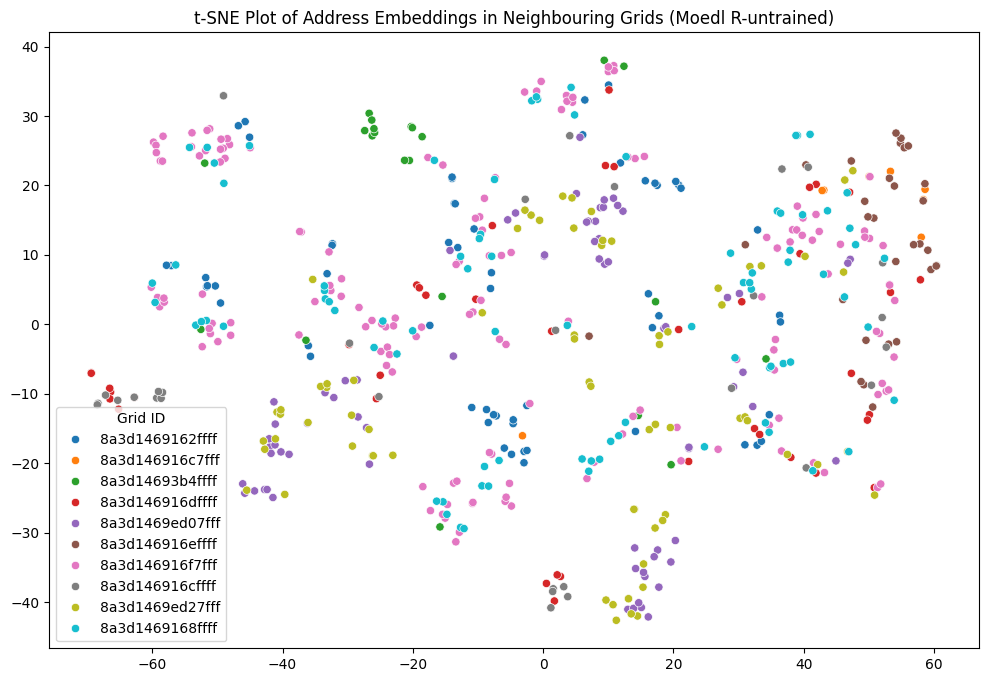

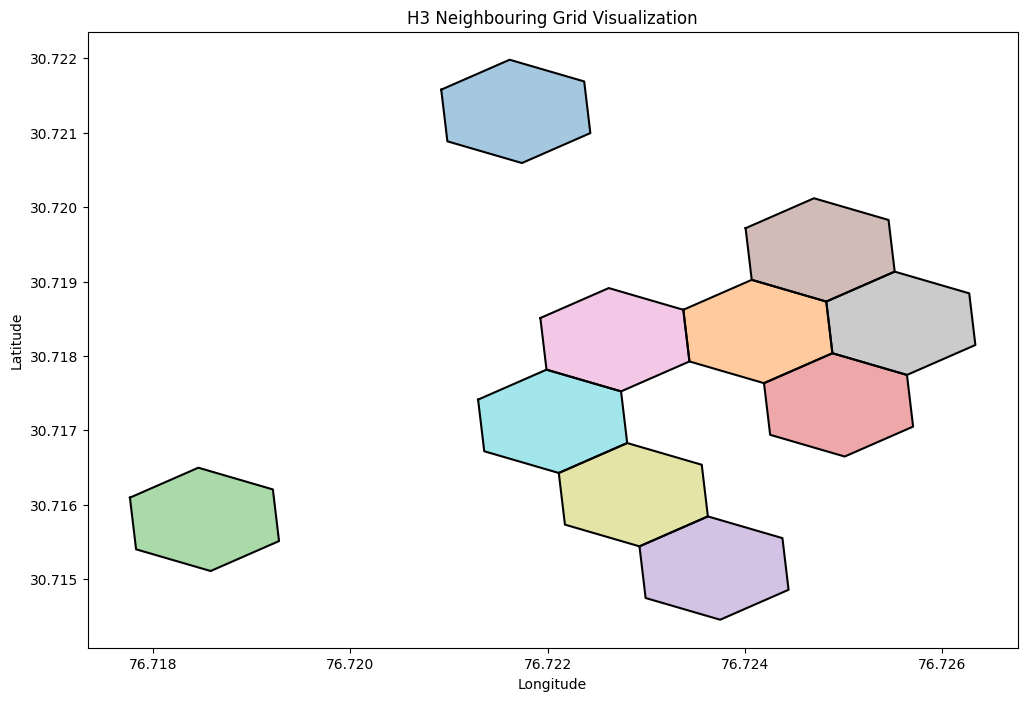

In [9]:
selected_grids = plot_tsne_of_neighbouring_grids(models, tokenizers, devices, addresses, lat_lngs, resolution=11, output_dir='output_plots', perplexity=10)
if selected_grids:
    plot_h3_grids_neighbours(lat_lngs, selected_grids, resolution=10, output_path='output_plots/h3_neighbouring_grids_plot.png')
    plot_h3_grids_folium_neighbours(lat_lngs, selected_grids, resolution=10, output_path='output_plots/h3_neighbouring_grids_map.html')

Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2354/2354 [00:25<00:00, 94.10it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


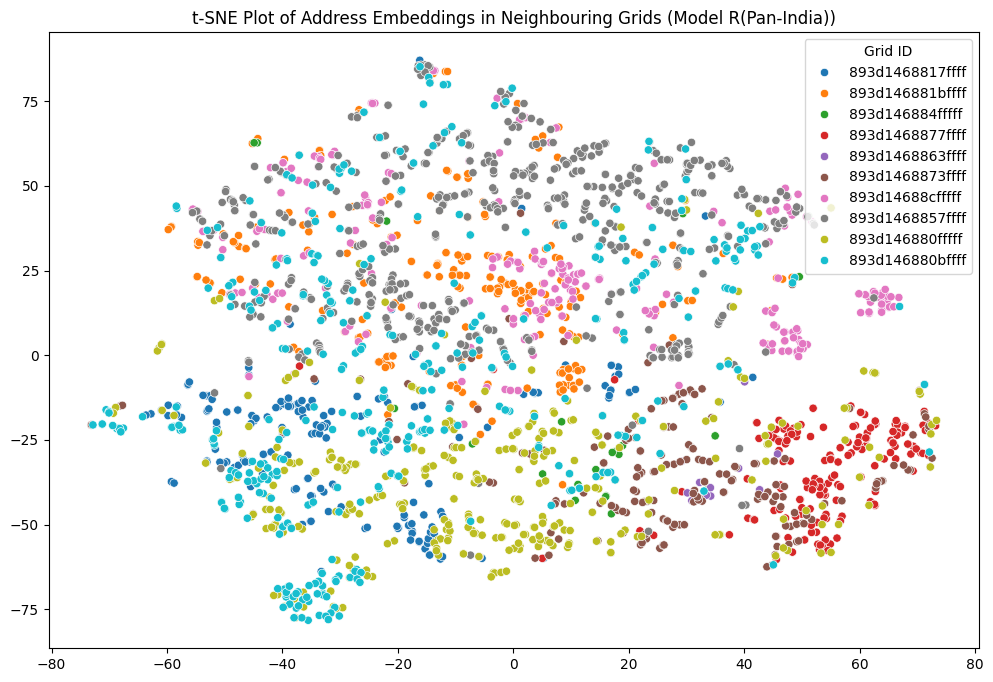

Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2354/2354 [00:24<00:00, 95.04it/s]


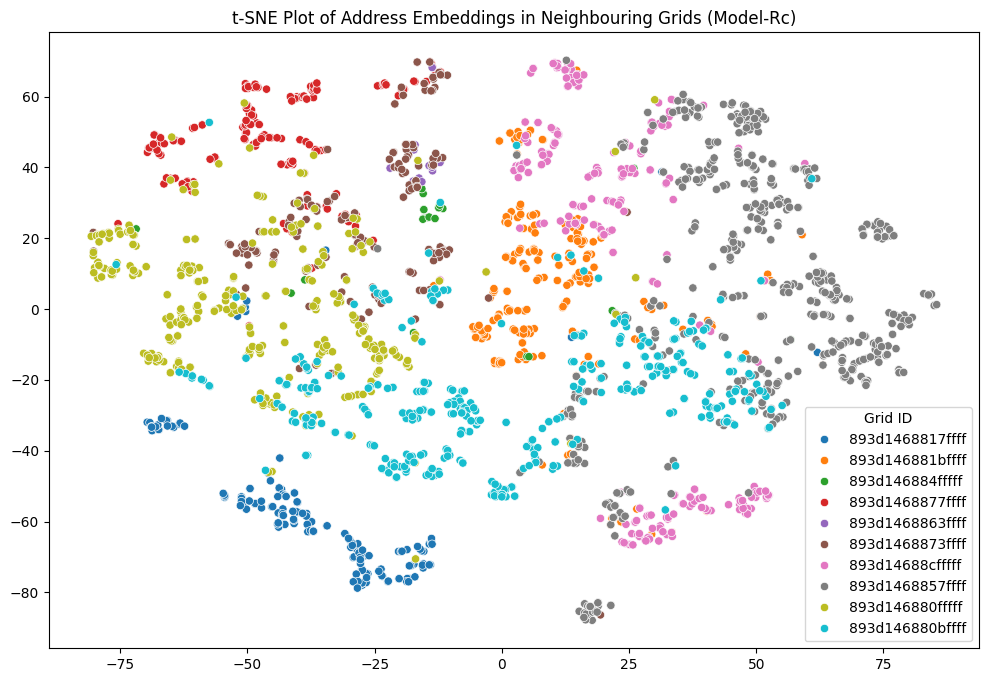

Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2354/2354 [00:24<00:00, 95.31it/s]


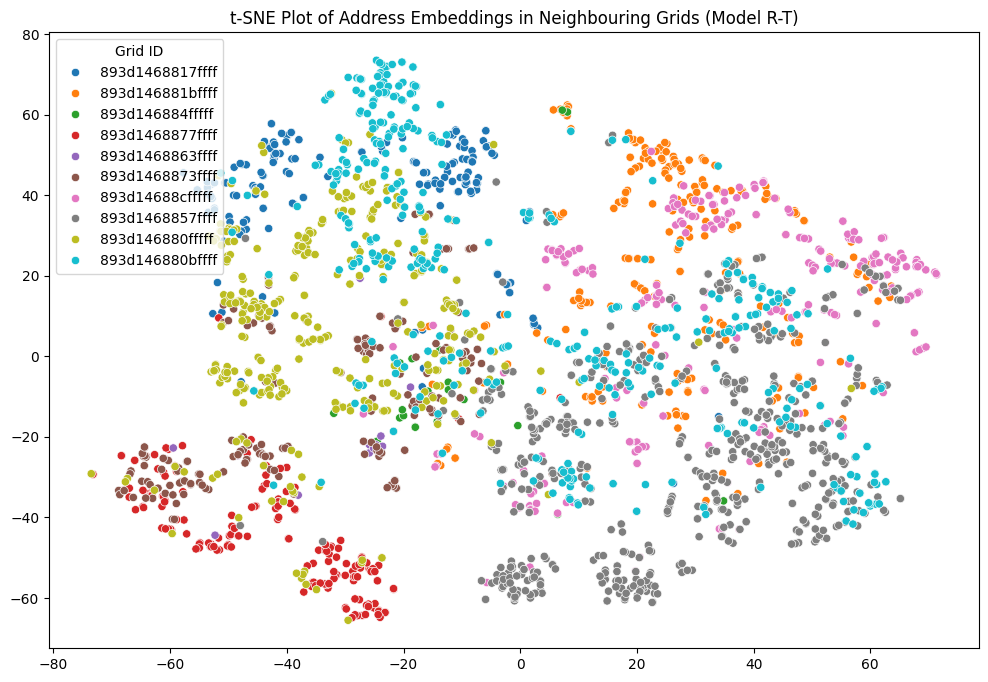

Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2354/2354 [00:25<00:00, 93.28it/s]


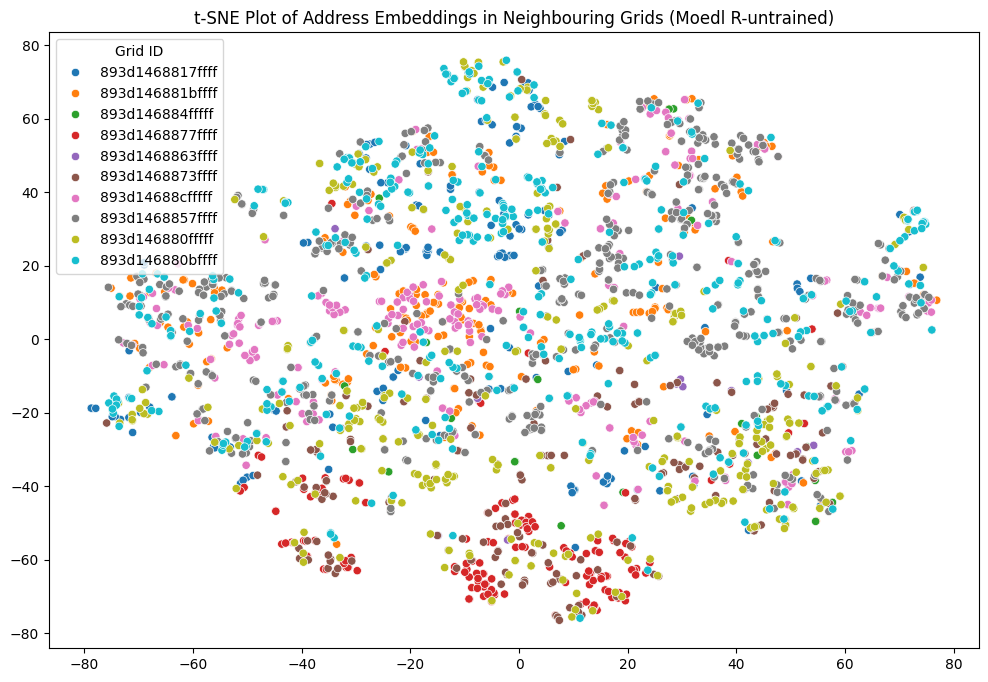

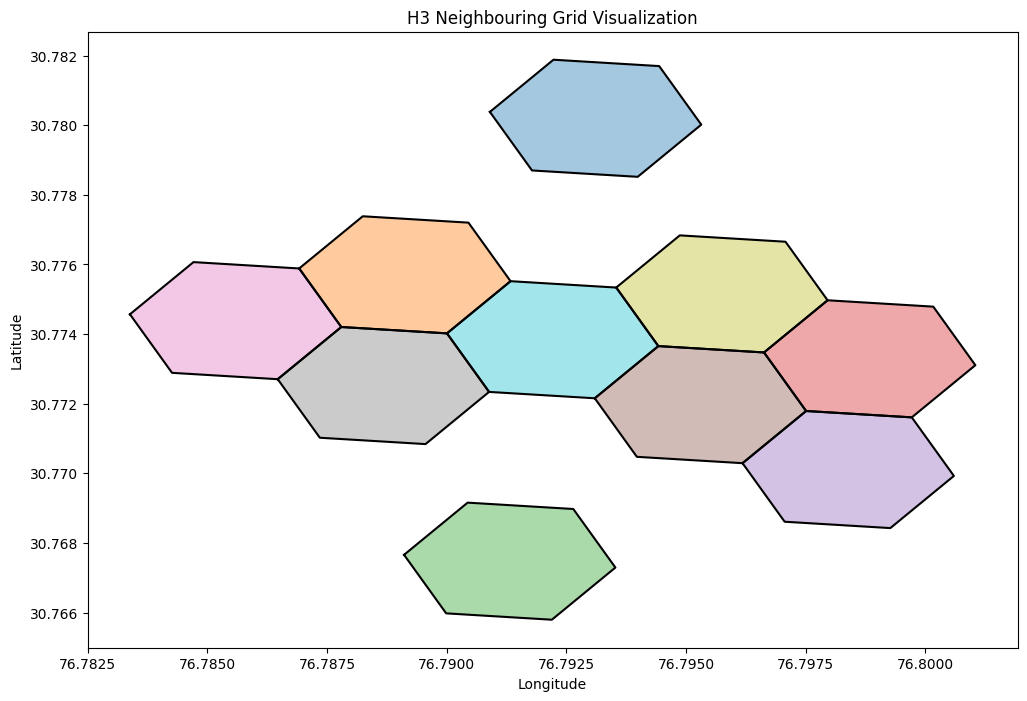

In [10]:
selected_grids = plot_tsne_of_neighbouring_grids(models, tokenizers, devices, addresses, lat_lngs, resolution=10, output_dir='output_plots', perplexity=10)
if selected_grids:
    plot_h3_grids_neighbours(lat_lngs, selected_grids, resolution=10, output_path='output_plots/h3_neighbouring_grids_plot.png')
    plot_h3_grids_folium_neighbours(lat_lngs, selected_grids, resolution=10, output_path='output_plots/h3_neighbouring_grids_map.html')

Computing embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 710/710 [00:07<00:00, 95.63it/s]


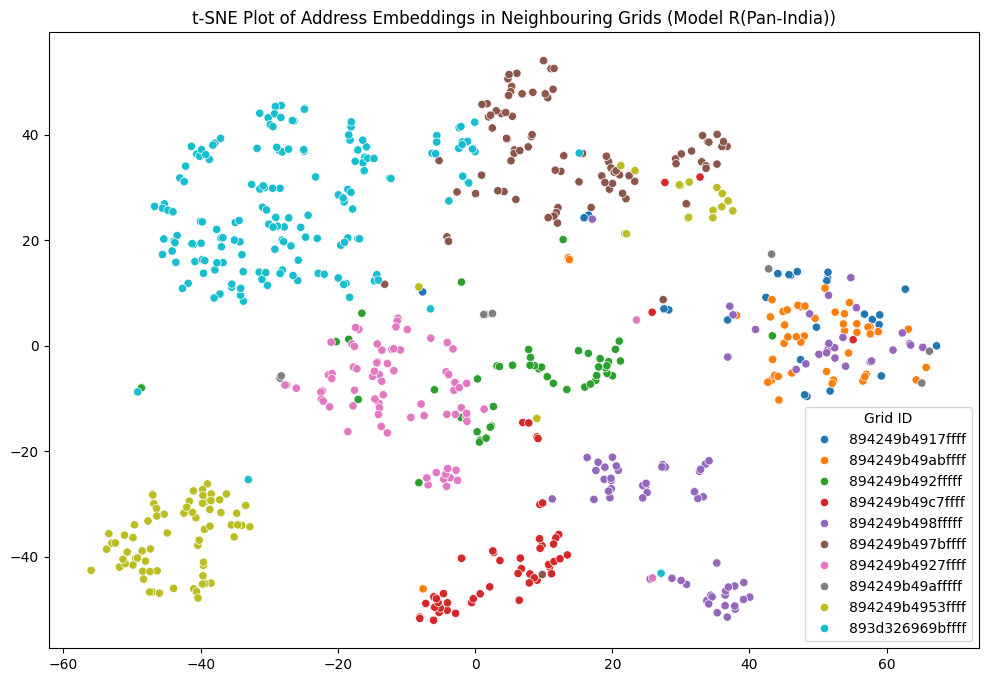

Computing embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 710/710 [00:07<00:00, 92.92it/s]


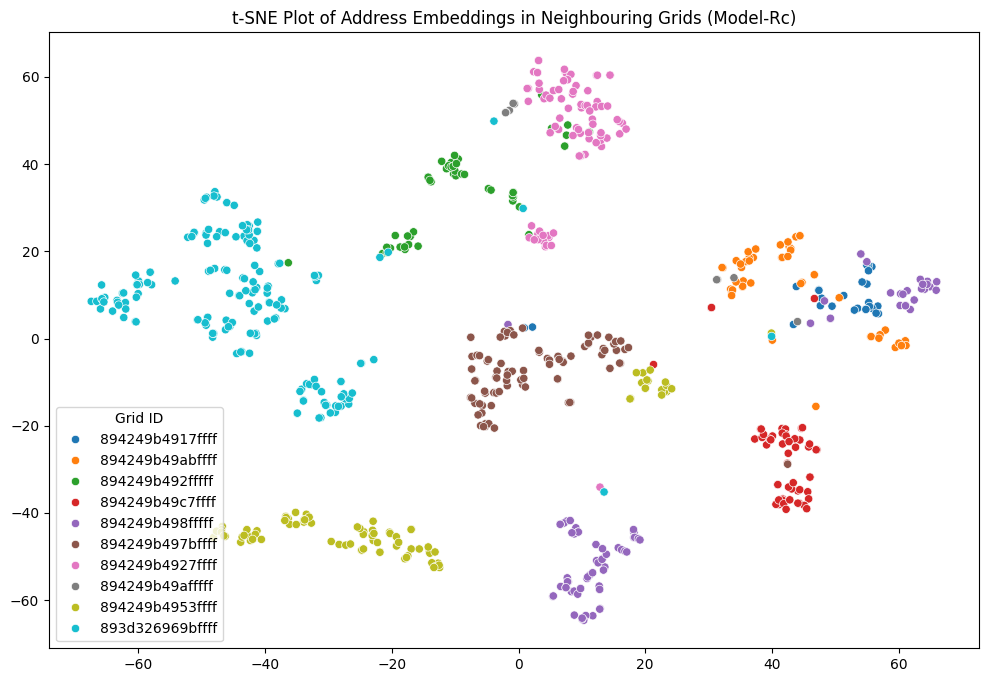

Computing embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 710/710 [00:07<00:00, 94.42it/s]


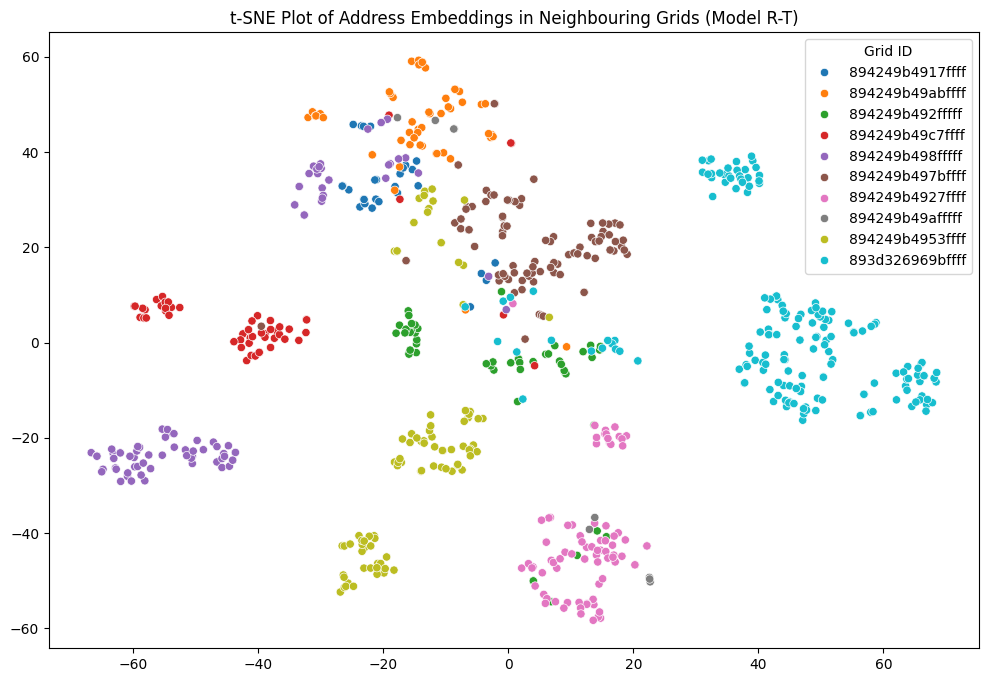

Computing embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 710/710 [00:07<00:00, 95.81it/s]


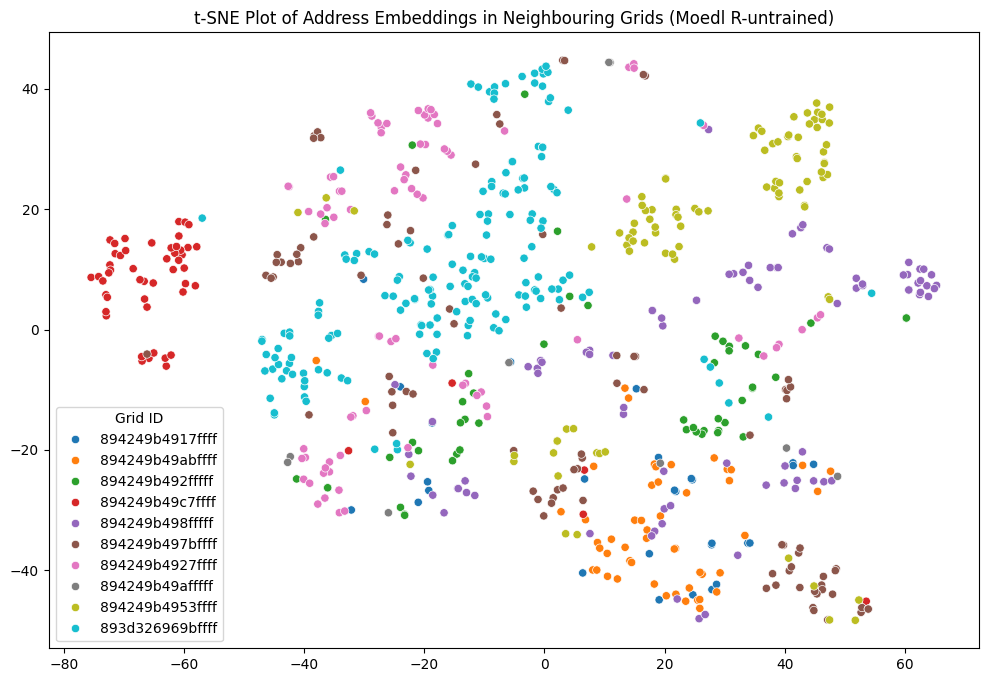

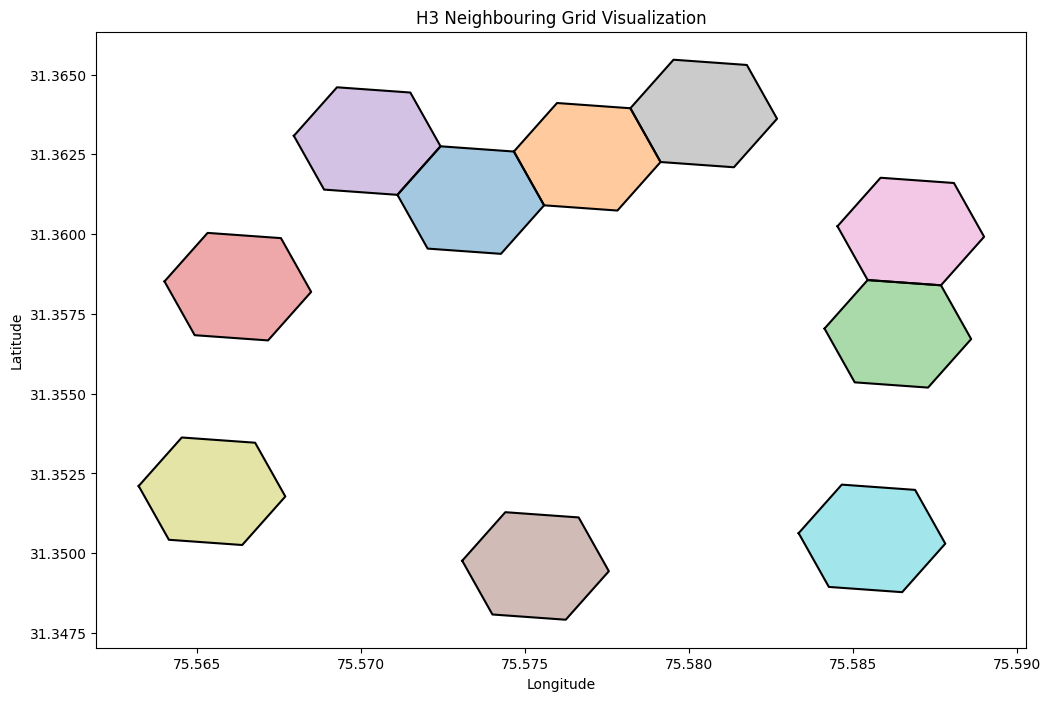

In [11]:
selected_grids = plot_tsne_of_neighbouring_grids(models, tokenizers, devices, addresses, lat_lngs, resolution=10, output_dir='output_plots', perplexity=10)
if selected_grids:
    plot_h3_grids_neighbours(lat_lngs, selected_grids, resolution=10, output_path='output_plots/h3_neighbouring_grids_plot.png')
    plot_h3_grids_folium_neighbours(lat_lngs, selected_grids, resolution=10, output_path='output_plots/h3_neighbouring_grids_map.html')